In [30]:
import os
import random
import  shutil
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import gradio as gr

In [3]:
dataset_dir = 'Downloads/archive/brain_tumor_dataset'
train_dir = 'Downloads/archive/brain_tumor_dataset/train'
validation_dir = 'Downloads/archive/brain_tumor_dataset/validation'

In [4]:
# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, 'no'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'yes'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'no'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'yes'), exist_ok=True)

In [6]:
# Function to split and move files
def split_and_move(class_name):
    class_dir = os.path.join(dataset_dir, class_name)
    images = [img for img in os.listdir(class_dir) if not img.startswith('.') and not img.endswith('.ipynb_checkpoints')]
    train_images, validation_images = train_test_split(images, test_size=0.2, random_state=42)
    
    for image in train_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(train_dir, class_name, image)
        shutil.copyfile(src, dst)
    
    for image in validation_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(validation_dir, class_name, image)
        shutil.copyfile(src, dst)

# Split and move 'no' class
split_and_move('no')

# Split and move 'yes' class
split_and_move('yes')


In [7]:

# Set up image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Load training images from the 'data/train' directory
train_generator = train_datagen.flow_from_directory(
    'Downloads/archive/brain_tumor_dataset/train',       # Path to the training data directory
    target_size=(150, 150),  # Resize all images to 150x150
    batch_size=32,
    class_mode='binary'  # Since it's binary classification (tumor vs no tumor)
)

# Load validation images from the 'data/validation' directory
validation_generator = validation_datagen.flow_from_directory(
    'Downloads/archive/brain_tumor_dataset/validation',  # Path to the validation data directory
    target_size=(150, 150),  # Resize all images to 150x150
    batch_size=32,
    class_mode='binary'
)

Found 211 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [8]:
# Load training images from the 'data/train' directory
train_generator = train_datagen.flow_from_directory(
    'Downloads/archive/brain_tumor_dataset/train',       # Path to the training data directory
    target_size=(150, 150),  # Resize all images to 150x150
    batch_size=32,
    class_mode='binary'  # Since it's binary classification (tumor vs no tumor)
)

# Load validation images from the 'data/validation' directory
validation_generator = validation_datagen.flow_from_directory(
    'Downloads/archive/brain_tumor_dataset/validation',  # Path to the validation data directory
    target_size=(150, 150),  # Resize all images to 150x150
    batch_size=32,
    class_mode='binary'
)

Found 211 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


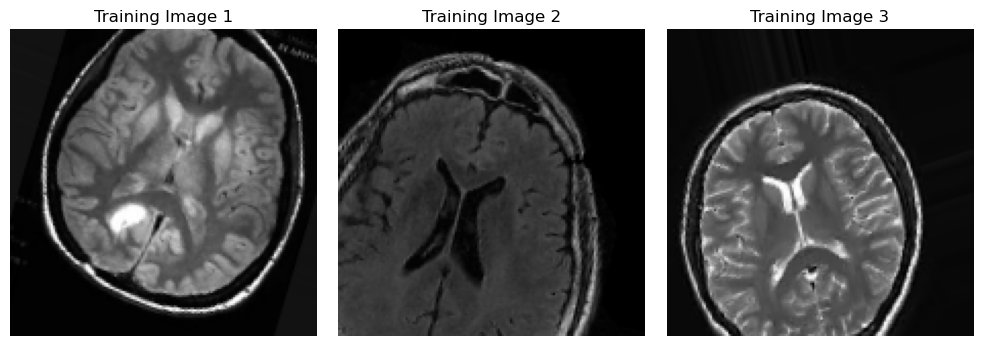

In [9]:
# Visualize a few images from the training set
sample_training_images, _ = next(train_generator)  # Get a batch of images and labels from the generator
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_training_images[i])
    plt.title(f"Training Image {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

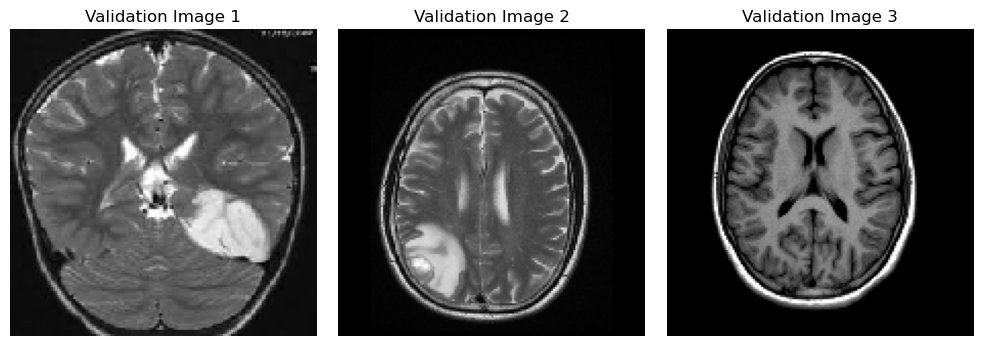

In [10]:
# Visualize a few images from the validation set
sample_validation_images, _ = next(validation_generator)  # Get a batch of images and labels from the generator
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_validation_images[i])
    plt.title(f"Validation Image {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [39]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [13]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
history = model.fit(train_generator, steps_per_epoch=100, epochs=20, validation_data=validation_generator, validation_steps=50)

Epoch 1/20


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  7/100 ━━━━━━━━━━━━━━━━━━━━ 48s 523ms/step - accuracy: 0.5274 - loss: 1.3445

C:\Users\admin\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.4953 - loss: 1.1408 - val_accuracy: 0.6863 - val_loss: 0.6650
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.6170 - loss: 0.6570 - val_accuracy: 0.6078 - val_loss: 0.6171
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.6196 - loss: 0.6376 - val_accuracy: 0.7059 - val_loss: 0.6151
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6608 - loss: 0.6211 - val_accuracy: 0.6078 - val_loss: 0.6620
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6313 - loss: 0.6352 - val_accuracy: 0.6863 - val_loss: 0.6098
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6166 - loss: 0.6483 - val_accuracy: 0.6275 - val_loss: 0.5825
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.6770 - loss: 0.6235 - val_accuracy: 0.6667 - val_loss: 0.5604
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.6477 - loss: 0.5991 - val_accuracy: 0.76

In [16]:
model.save('my_model.keras')

In [17]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8772 - loss: 0.4361
Validation Loss: 0.4528197944164276
Validation Accuracy: 0.8627451062202454


In [18]:
# Load the saved model
savmodel = load_model('my_model.keras')

In [19]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Resize image to 150x150
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create a batch of size 1
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

In [20]:
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    prediction = model.predict(img_array)
    probability = prediction[0][0]
    if probability > 0.5:
        return "yes", probability * 100
    else:
        return "no", (1 - probability) * 100


In [21]:
# Get the true labels and predictions
validation_generator.reset()
y_true = []
y_pred = []
for _ in range(len(validation_generator)):
   x_batch, y_batch = next(validation_generator)
   y_true.extend(y_batch)
   y_pred_batch = model.predict(x_batch)
   y_pred.extend(y_pred_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


In [23]:
# Convert predictions to binary class labels
y_pred = np.array(y_pred) > 0.5
y_true = np.array(y_true)

In [26]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[14  6]
 [ 1 30]]


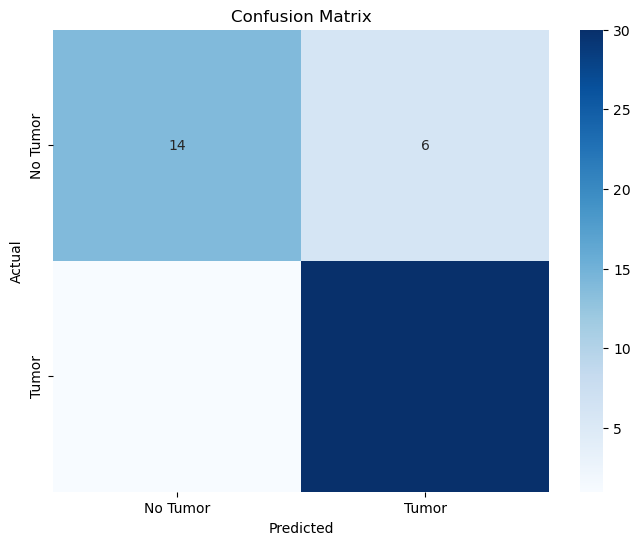

In [28]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [29]:
 # Print classification report
 print("Classification Report:")
 print(classification_report(y_true, y_pred, target_names=["No Tumor", "Tumor"]))

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.93      0.70      0.80        20
       Tumor       0.83      0.97      0.90        31

    accuracy                           0.86        51
   macro avg       0.88      0.83      0.85        51
weighted avg       0.87      0.86      0.86        51



In [37]:
def classify_image(img):
    result, probability = predict_image(model, img)
    return f"{result} ({probability:.2f}%)"

In [40]:
# Create the Gradio interface
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="filepath"),
    outputs="text",
    title="Brain Tumor Classifier",
    description="Upload an MRI image to classify if it has a brain tumor or not.",
    examples=["Downloads/archive/no/10 no.jpg", "Downloads/archive/yes/Y100.JPG"]
)

# Launch the interface
interface.launch()

Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
